### A bit about the data:

- 11350 unique users
- 3600 unique games

In [9]:
%matplotlib inline

import matplotlib
import time
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

In [11]:
# %load preprocessing.py
#!/usr/bin/env python3
"""
Created on Wed Nov  7 02:03:28 2018

@author: james.f.xue
"""

import pandas as pd
import numpy as np
import random

#%%

raw_file_location = "../data/raw/steam-200k.csv"
processed_directory = "../data/processed"
header_names = ['user_id', 'game_name', 'purchase-play', 'indicator-hours', 'empty']
data = pd.read_csv(raw_file_location, names=header_names)

#%%

class preprocessing: 
    """
    Tidying Data
    """
    def tidy(self, data, processed_directory): 
        #subset data into a purchase dataset and a play dataset based on purchase-play
        purchase = data.loc[data['purchase-play'] == 'purchase']
        play = data.loc[data['purchase-play'] == 'play']
    
        """Remove the empty column"""
        play = play[['user_id', 'game_name', 'indicator-hours']]
    
        """Save this file as a csv"""
        play.to_csv(processed_directory+"/play_tidy.csv")
        
        return play
        
    def subsample_random(self, processed_directory, k): 
        """Read the Data"""
        play_tidy = pd.read_csv(processed_directory+"/play_tidy.csv", ",")
        play_tidy.head()
    
        """sub sample the games to 100 from 3.6k games for a simple model"""
        unique_users = play_tidy['user_id'].unique()
        unique_games = play_tidy['game_name'].unique()
    
        #generate random 100 games
        random_indices = random.sample(range(0, len(unique_games)), k)
        random_100games = unique_games[random_indices]
    
        #select games from dataframe
        play_tidy_100games = play_tidy.loc[play_tidy['game_name'].isin(random_100games)]
        len(play_tidy_100games['user_id'].unique()) #931 unique users
        play_tidy_100games = play_tidy_100games.drop(['Unnamed: 0'], axis=1)
    
        #save to csv
        play_tidy_100games.to_csv(processed_directory+"/play_tidy_random.csv")
    
        return play_tidy_100games
    
    def subsample_top(self, processed_directory, k): 
        #returns games purchased by over 100 users
        """Read the Data"""
        play_tidy = pd.read_csv(processed_directory+"/play_tidy.csv", ",")
        play_tidy = play_tidy.drop(['Unnamed: 0'], axis=1)
    
        """sub sample the games to 100 from 3.6k games for a simple model"""
        unique_users = play_tidy['user_id'].unique()
        unique_games = play_tidy['game_name'].unique()
        
        """Generate Top 100 Games by Purchase Count""" 
        purchase_counts = (play_tidy.set_index(["game_name", 'user_id']).count(level='game_name'))
        purchase_counts = purchase_counts[purchase_counts['indicator-hours'] > k]
        top_games = purchase_counts.index
        
        top_filter = play_tidy['game_name'].isin(top_games)
        
        play_tidy_top = play_tidy[top_filter]
        play_tidy_top.to_csv(processed_directory+"/play_tidy_top.csv")
        
        return play_tidy_top
            
        
    def one_hot_random(self, processed_directory): 
        """One Hot Encode Results"""
        
        play_tidy_100games = pd.read_csv(processed_directory+"/play_tidy_random.csv", ",")
        play_dummies = pd.get_dummies(play_tidy_100games['game_name'])
        one_hot_random = pd.concat([play_tidy_100games['user_id'], play_dummies], axis=1)
        one_hot_random.to_csv(processed_directory+"/one_hot_random.csv")
        
        return one_hot_random
    
    def one_hot_top(self, processed_directory): 
        """One Hot Encode Results"""
        
        play_tidy_100games = pd.read_csv(processed_directory+"/play_tidy_top.csv", ",")
        play_dummies = pd.get_dummies(play_tidy_100games['game_name'])
        one_hot_top = pd.concat([play_tidy_100games['user_id'], play_dummies], axis=1)
        one_hot_top.to_csv(processed_directory+"/one_hot_top.csv")
        
        return one_hot_top
    
    def collapsed_random(self, processed_directory): 
        """Collapsed One-Hot by User"""
        one_hot_100games = pd.read_csv(processed_directory+"/one_hot_random.csv", ",")
        one_hot_collapsed = one_hot_100games.groupby(['user_id']).sum()
        one_hot_collapsed = one_hot_collapsed.drop(['Unnamed: 0'], axis=1)
        one_hot_collapsed.to_csv(processed_directory+"/one_hot_collapsed_random.csv")
        return one_hot_collapsed
    
    def collapsed_top(self, processed_directory): 
        """Collapsed One-Hot by User"""
        one_hot_100games = pd.read_csv(processed_directory+"/one_hot_top.csv", ",")
        one_hot_collapsed = one_hot_100games.groupby(['user_id']).sum()
        one_hot_collapsed = one_hot_collapsed.drop(['Unnamed: 0'], axis=1)
        one_hot_collapsed.to_csv(processed_directory+"/one_hot_collapsed_top.csv")
        return one_hot_collapsed
    
    def playtime_random(self, processed_directory): 
        """Take the tidy data and enhance the one-hot data""" 
        tidy = pd.read_csv(processed_directory+"/play_tidy_random.csv", ",")
        tidy = tidy.drop(['Unnamed: 0'], axis=1)
        onehot = pd.read_csv(processed_directory+"/one_hot_random.csv", ",").drop(['Unnamed: 0'], axis=1)
        tidy_array = np.array(tidy)
        
        for row in tidy_array: 
            user = row[0]
            game = row[1]
            time = row[2]
            onehot.loc[onehot.user_id == user, game] = time
        
        """Collapse This"""
        onehot = onehot.groupby(['user_id']).sum() 
        onehot.to_csv(processed_directory+"/one_hot_playtime_random.csv")
        
        return onehot
    
    def playtime_top(self, processed_directory): 
        """Take the tidy data and enhance the one-hot data""" 
        tidy = pd.read_csv(processed_directory+"/play_tidy_top.csv", ",")
        tidy = tidy.drop(['Unnamed: 0'], axis=1)
        onehot = pd.read_csv(processed_directory+"/one_hot_top.csv", ",").drop(['Unnamed: 0'], axis=1)
        tidy_array = np.array(tidy)
        
        for row in tidy_array: 
            user = row[0]
            game = row[1]
            time = row[2]
            onehot.loc[onehot.user_id == user, game] = time
        
        onehot = onehot.groupby(['user_id']).sum() 
        onehot.to_csv(processed_directory+"/one_hot_playtime_top.csv")
        
        return onehot
        


(10181, 133)

# Prediction and Evaluation

In [18]:
# %load neighbor.py
#!/usr/bin/env python3
"""
Created on Wed Nov  7 02:01:52 2018

@author: james.f.xue
"""

#%%
import numpy as np
import math 
import pandas as pd
import random

processed_directory = "../data/processed"
output_directory = "../data/output"

#%%
class Similarity: 
        
    def inner_product(self, u, v): 
        return np.dot(u, v)
    
    def cosine_similarity(self, u, v): 
        return (np.dot(u, v))/(math.sqrt(np.dot(u, u))*math.sqrt(np.dot(v, v)))
    
    def pearson_similarity(self, u, v): 
        #make this for nonzero only
        mean_u = np.mean(u)
        mean_v = np.mean(v)
        
        u_centered = u-mean_u 
        v_centered = v-mean_v 
        top = (np.dot(u_centered, v_centered))
        bot = (math.sqrt(np.dot(u_centered, u_centered))*math.sqrt(np.dot(v_centered, v_centered)))
        if bot == 0: 
            result = 0 
        else: 
            result = top/bot
        
        return result
        
    """TODO FIX""" 
    def user_based(self, dataframe, *metric): 
        (Y, X) = matrix.shape 
        result_matrix = np.empty((Y, Y))
        #for each row in matrix, iterate through all the rows
        
        for i, row_i in enumerate(matrix): 
            for j, row_j in enumerate(matrix): 
                if metric == "cosine": 
                    score = self.cosine_similarity(row_i, row_j)
                else: 
                    score = self.pearson_similarity(row_i, row_j)
                result_matrix[i, j] = score 
                
        return result_matrix 

#%%
sim= Similarity() 
sim.pearson_similarity([0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0, 0, 0, 0])

#%%
class NeighborPredict(): 
    
    def purchase_predict(self, onehot_data, output_directory, k_neighbors): 
        df = pd.read_csv(onehot_data, ",").drop(['Unnamed: 0'], axis=1) 
        df_columns = df.columns
#        print(df_columns) 
        onehot_array = np.array(df)
        users = onehot_array[:, 0]
        onehot_games = onehot_array[:, 1:]
        sim = Similarity()
        
        """Create Similarity Matrix""" 
        similarity_matrix = np.empty((len(users), len(users)))
        
        """TODO Rerun this""" 
        """Begin Toggler""" 
        for i, row1 in enumerate(onehot_games): 
            for j, row2 in enumerate(onehot_games): 
                if (i!=j): 
                    similarity_matrix[i][j] = sim.cosine_similarity(row1, row2)
                else: 
                    similarity_matrix[i][j] = 0 

        temp = pd.DataFrame(similarity_matrix)
        temp.to_csv(output_directory+"/similarity_matrix_purchase.csv")
        """End Toggler""" 
        
        temp = pd.read_csv(output_directory+"/similarity_matrix_purchase.csv", ",").drop(['Unnamed: 0'], axis=1)
        similarity_matrix = np.array(temp)
        
        for i, row in enumerate(onehot_games): 
            """Change for Time Case, nonzero Average doesn't mean much here since it's all 1""" 
            user_average = np.mean(row) #don't use here
            for j, purchase in enumerate(row):
                if purchase == 0: 
                    similarity_array = similarity_matrix[i]
                    mask = (onehot_games[:, j] > 0)
                    masked_similarity = similarity_array[mask]
                    top_k_indices = masked_similarity.argsort()[-k_neighbors:][::-1]
                    
                    """We run into the problem where the number of neighbors is less than k"""
                    top = 0
                    bottom = 0 
                    for index in top_k_indices: 
                        if masked_similarity[index] != 0 : 
                            print(masked_similarity[index])
                            top += masked_similarity[index] 
                            bottom += 1
                    
                    if bottom == 0 : 
                        onehot_games[i][j] == 0
                    elif (top/bottom > 0): #change to 0.5
                        onehot_games[i][j] == 1
                        print("found")

        
#        result = np.concatenate((nonehot_games), axis=1)      
        result = pd.DataFrame(onehot_games, columns = df_columns[1:]) #set column names
        result.to_csv(output_directory+"/predicted_onehot_purchase_random.csv")
        
        return result.shape 
    
    def playtime_predict(self, onehot_data, similarity_name, output_name, k_neighbors, k_hours): 
        df = pd.read_csv(onehot_data, ",")
        df_columns = df.columns
#        print(len(df_columns))
#        print(df_columns) 
        onehot_array = np.array(df)
        users = onehot_array[:, 0]
        onehot_games = onehot_array[:, 1:]
        sim = Similarity()
        
#        print(len(users))
#        print(onehot_games.shape)
        
        """Create Similarity Matrix""" 
        similarity_matrix = np.empty((len(users), len(users)))
        
        """TODO Rerun this""" 
        """Begin Toggler""" 
        for i, row1 in enumerate(onehot_games): 
            for j, row2 in enumerate(onehot_games): 
                if (i!=j): 
                    similarity_matrix[i][j] = sim.pearson_similarity(row1, row2)
                else: 
                    similarity_matrix[i][j] = 0 
        
        temp = pd.DataFrame(similarity_matrix)
        temp.to_csv(similarity_name)
        print("similarity_matrix")
        """End Toggler""" 
        
        temp = pd.read_csv(similarity_name, ",").drop(['Unnamed: 0'], axis=1)
        similarity_matrix = np.array(temp)
#        print(temp)
        
        nonzero_average_matrix = []
        for row in onehot_games: 
            if np.count_nonzero(row) != 0:     
                average = sum(row)/np.count_nonzero(row)
                nonzero_average_matrix.append(average)
            else: 
                nonzero_average_matrix.append(0)
        
        num_games = onehot_games.shape[1]
        coverage_array = np.zeros(num_games) 
        hours = k_hours 
        for i, row in enumerate(onehot_games): 
            """Change for Time Case, nonzero Average doesn't mean much here since it's all 1""" 
            for j, purchase in enumerate(row):
                if purchase == 0: 
                    similarity_array = similarity_matrix[i]
                    mask = (onehot_games[:, j] > 0)
                    masked_similarity = similarity_array[mask]
                    top_k_indices = masked_similarity.argsort()[-k_neighbors:][::-1]
                    
                    """We run into the problem where the number of neighbors is less than k"""
                    top = 0
                    bottom = 0 
                    for index in top_k_indices: 
                        if masked_similarity[index] != 0 :
                            """Mean Subtraction Removed due to undue disturbances""" 
                            top += masked_similarity[index] * (onehot_games[index][j]) #- nonzero_average_matrix[index]
                            bottom += abs(masked_similarity[index])
                    
                    if bottom == 0 : 
                        onehot_games[i][j] == 0
                    else: #change to 0.5
#                        print(bottom)
                        onehot_games[i][j] ==  top/bottom
                        if top/bottom > hours: 
                            coverage_array[j] = 1 
                        
        coverage = sum(coverage_array)/num_games
        print("Coverage is ", coverage)
        
#        result = np.concatenate((nonehot_games), axis=1)   
        users = pd.DataFrame(users)
        onehot_games = pd.DataFrame(onehot_games)
#        print(onehot_games.shape)
        result = pd.concat([users, onehot_games], axis=1)
#        print(result.shape)
        result.columns = df_columns
        result.to_csv(output_name)
        
        return result, coverage 

        



#%%
purchase_random = processed_directory+"/one_hot_random.csv"
purchase_top = processed_directory+"/one_hot_top.csv"
playtime_random = processed_directory+"/one_hot_playtime_random.csv"
playtime_top = processed_directory+"/one_hot_playtime_top.csv"

purchase_random_predict = output_directory+"/one_hot_random_predict.csv"
purchase_top_predict = output_directory+"/one_hot_top_predict.csv"
playtime_random_predict = output_directory+"/one_hot_playtime_random_predict.csv"
playtime_top_predict = output_directory+"/one_hot_playtime_top_predict.csv"

playtime_similarity_top_predict = output_directory+"/similarity_playtime_top_predict.csv"
playtime_similarity_random_predict = output_directory+"/similarity_playtime_random_predict.csv"

#%%
neighbor = NeighborPredict() 
neighbor.playtime_predict(playtime_random, playtime_similarity_random_predict, playtime_top_predict, 5, 1)
#purchase = neighbor.playtime_predict(loc, filename, 10)



#%%

class Evaluation: 
    
    def cross_validate(self, tidy_df, onehot_df, train=0.7, val=0.15, test= 0.15): 
        row_length = tidy_df.shape[0]
        train_length = int(row_length * train)
        val_length = int(row_length * val)
        indices = list(range(0, row_length))
#        print(indices)
        
        train_indices = random.sample((indices), train_length)
#        print(len(train_indices))
        train_split = tidy_df.iloc[train_indices]
        
        new_indices = []
        for i in indices: 
            if i not in train_indices: 
                new_indices.append(i)
#        print(new_indices)
        val_indices = random.sample((new_indices), val_length)
        val_split = tidy_df.iloc[val_indices]
        
        newest_indices = []
        for i in new_indices: 
            if i not in val_indices: 
                newest_indices.append(i)
        
#        print(newest_indices)
        test_split = tidy_df.iloc[newest_indices]
        
        """Remove Val Split and Test Split from Onehot df"""
        withhold_split = pd.concat([val_split, test_split])
        withhold_np = np.array(withhold_split)
        for row in withhold_np: 
#            print("row", row)
            user = row[0]
            game = row[1]
            onehot_df.loc[onehot_df.user_id == user, game] = 0
        
        onehot_df.to_csv(processed_directory+"/one_hot_playtime_crossvalidated.csv")
        print("saved")

        return train_split, val_split, test_split, onehot_df
        
    
    def accuracy(self, prediction_matrix, val, test): 
        
        """Giving the outlier prone nature of our data, MAE is a good fit"""
        """RMSE is also ok""" 
        val_MAE = 0 
        val_RMSE = 0 
        test_MAE = 0 
        test_RMSE = 0
        
        val_split = np.array(val)
        test_split = np.array(test)
        
        for row in val_split: 
            user = row[0]
            game = row[1]
            time = row[2]
            
            prediction =  np.array(prediction_matrix.loc[prediction_matrix.user_id == user, game])[0]
            print(prediction)
            
            abs_diff = abs(time-prediction)
            sq_diff = abs_diff ** 2 
            val_MAE += abs_diff
            val_RMSE += sq_diff
            
        val_len = val_split.shape[1]
        val_MAE = val_MAE / val_len
        val_RMSE = math.sqrt(val_RMSE / val_len)
        
        
        for row in test_split: 
            user = row[0]
            game = row[1]
            time = row[2]
#            print(user, game, time)
            

            prediction = np.array(prediction_matrix.loc[prediction_matrix.user_id == user, game])[0]
            print(prediction)
            
            abs_diff = abs(time-prediction)
            sq_diff = abs_diff ** 2 
            test_MAE += abs_diff
            test_RMSE += sq_diff
            
        test_len = test_split.shape[1]
        test_MAE = test_MAE / test_len
        test_RMSE = math.sqrt(test_RMSE / test_len)
        
        print(val_MAE, val_RMSE, test_MAE, test_RMSE)
        
        return val_MAE, val_RMSE, test_MAE, test_RMSE


#%%
ev = Evaluation()
tidy1 = pd.read_csv(processed_directory+"/play_tidy_random.csv", ",").drop(['Unnamed: 0'], axis=1)
onehot1 = pd.read_csv(processed_directory+"/one_hot_playtime_random.csv", ",")
train, val, test, onehot_df = ev.cross_validate(tidy1, onehot1)
#%%
#playtime_random_cv = pd.read_csv(processed_directory+"/one_hot_playtime_crossvalidated.csv").drop(['Unnamed: 0'], axis=1)
playtime_random_cv = processed_directory+"/one_hot_playtime_crossvalidated.csv"
temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, 5, 1)

#%%
val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
"""All zeroes: 3938.3000000000015 1452.8606138695247 3417.9666666666653 2186.2875100651027"""
#%%



#%%

similarity_matrix
Coverage is  0.13
saved
similarity_matrix
Coverage is  0.09900990099009901
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

'All zeroes: 3938.3000000000015 1452.8606138695247 3417.9666666666653 2186.2875100651027'

# Hyperparameter Tuning

### Neighborhood Size

In [4]:
neighborhood_size = [1, 2, 4, 8]
min_hours_played = [1, 4, 16]
val11 = []
val12 = []
test13 = [] 
test14 = [] 
coverage = []


for size in neighborhood_size: 
    temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, size, 1)
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    coverage.append(covarage_result)
    val11.append(val1)
    val12.append(val2)
    test13.append(test1)
    test14.append(test2)

print(val11, val12, val13, val14)

similarity_matrix
Coverage is  0.10891089108910891
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

NameError: name 'val13' is not defined

<function matplotlib.pyplot.show>

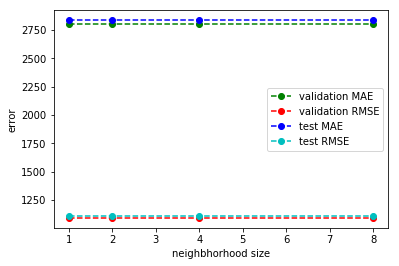

In [5]:
plt.plot(neighborhood_size, val11, 'go--', label="validation MAE")
plt.plot(neighborhood_size, val12, 'ro--', label="validation RMSE")
plt.plot(neighborhood_size, test13, 'bo--', label = "test MAE")
plt.plot(neighborhood_size, test14, 'co--', label = "test RMSE")
plt.xlabel('neighbhorhood size')
plt.ylabel('error')
plt.legend()
plt.show

### coverage

In [6]:
min_hours_played = [1, 4, 16]
val21 = []
val22 = []
test23 = [] 
test24 = [] 
coverage = []

for hour in min_hours_played: 
    temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, 5, size)
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    val21.append(val1)
    val22.append(val2)
    test23.append(test1)
    test24.append(test2)
    coverage.append(covarage_result)



similarity_matrix
Coverage is  0.06930693069306931
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

<function matplotlib.pyplot.show>

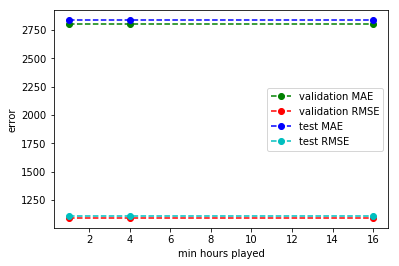

In [7]:
plt.plot(min_hours_played, val21, 'go--', label="validation MAE")
plt.plot(min_hours_played, val22, 'ro--', label="validation RMSE")
plt.plot(min_hours_played, test23, 'bo--', label = "test MAE")
plt.plot(min_hours_played, test24, 'co--', label = "test RMSE")
plt.xlabel('min hours played')
plt.ylabel('error')
plt.legend()
plt.show

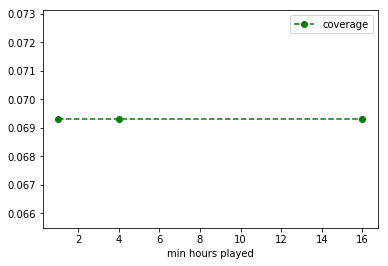

In [8]:
plt.plot(min_hours_played, coverage, 'go--', label="coverage")
plt.xlabel('min hours played')
plt.legend()
plt.show() 

In [14]:
model_size = [25, 50, 75, 100]
val31 = []
val32 = []
test33 = [] 
test34 = [] 
runtime = [] 

pre = preprocessing() 
for k in model_size: 
    
    start = time.time() 
    pre.subsample_random(processed_directory, k)
    pre.one_hot_random(processed_directory)
    pre.playtime_random(processed_directory)
    
    ev = Evaluation()
    tidy1 = pd.read_csv(processed_directory+"/play_tidy_random.csv", ",").drop(['Unnamed: 0'], axis=1)
    onehot1 = pd.read_csv(processed_directory+"/one_hot_playtime_random.csv", ",")
    train, val, test, onehot_df = ev.cross_validate(tidy1, onehot1)
   
    playtime_random_cv = processed_directory+"/one_hot_playtime_crossvalidated.csv"
    temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, 5, 1)

    #%%
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    end = time.time() - start 
    
    val31.append(val1)
    val32.append(val2)
    test33.append(test1)
    test34.append(test2)
    runtime.append(end)
    
print(val31, val32, test33, test34)
    



saved
similarity_matrix
Coverage is  0.038461538461538464
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
245.66666666666666 279.35830039574626 34.9 26.348371233658195
saved
similarity_matrix
Coverage is  0.0196078431372549
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [15]:
val31


[245.66666666666666, 1267.2000000000003, 518.6333333333331, 4948.733333333338]

<function matplotlib.pyplot.show>

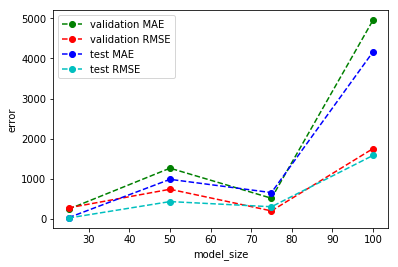

In [17]:
plt.plot(model_size, val31, 'go--', label="validation MAE")
plt.plot(model_size, val32, 'ro--', label="validation RMSE")
plt.plot(model_size, test33, 'bo--', label = "test MAE")
plt.plot(model_size, test34, 'co--', label = "test RMSE")
plt.xlabel('model_size')
plt.ylabel('error')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

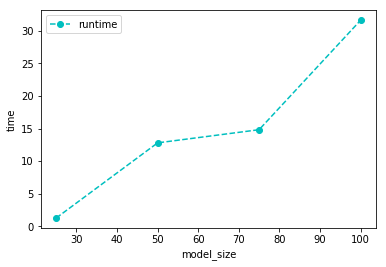

In [16]:
plt.plot(model_size, runtime, 'co--', label = "runtime")
plt.xlabel('model_size')
plt.ylabel('time')
plt.legend()
plt.show

### Top Games

In [ ]:
model_size = [25, 50, 75, 100]
val31 = []
val32 = []
test33 = [] 
test34 = [] 
runtime = [] 

pre = preprocessing() 
for k in model_size: 
    
    start = time.time() 
    pre.subsample_top(processed_directory, k)
    pre.one_hot_top(processed_directory)
    pre.playtime_top(processed_directory)
    
    ev = Evaluation()
    tidy1 = pd.read_csv(processed_directory+"/play_tidy_top.csv", ",").drop(['Unnamed: 0'], axis=1)
    onehot1 = pd.read_csv(processed_directory+"/one_hot_playtime_top.csv", ",")
    train, val, test, onehot_df = ev.cross_validate(tidy1, onehot1)
   
    playtime_top_cv = processed_directory+"/one_hot_playtime_crossvalidated.csv"
    temp_result, covarage_result = neighbor.playtime_predict(playtime_top_cv, playtime_similarity_top_predict, playtime_top_predict, 5, 1)

    #%%
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    end = time.time() - start 
    
    val31.append(val1)
    val32.append(val2)
    test33.append(test1)
    test34.append(test2)
    runtime.append(end)
    
print(val31, val32, test33, test34)

saved


In [ ]:
plt.plot(model_size, val31, 'go--', label="validation MAE")
plt.plot(model_size, val32, 'ro--', label="validation RMSE")
plt.plot(model_size, test33, 'bo--', label = "test MAE")
plt.plot(model_size, test34, 'co--', label = "test RMSE")
plt.xlabel('model_size')
plt.ylabel('error')
plt.legend()
plt.show

In [ ]:
plt.plot(model_size, runtime, 'co--', label = "runtime")
plt.xlabel('model_size')
plt.ylabel('time')
plt.legend()
plt.show

In [ ]:
min_hours_played = [1, 4, 16]
val21 = []
val22 = []
test23 = [] 
test24 = [] 
coverage = []

for hour in min_hours_played: 
    temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, 5, size)
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    val21.append(val1)
    val22.append(val2)
    test23.append(test1)
    test24.append(test2)
    coverage.append(covarage_result)

In [ ]:
plt.plot(min_hours_played, coverage, 'go--', label="coverage")
plt.xlabel('min hours played')
plt.legend()
plt.show() 

In [ ]:
neighborhood_size = [1, 2, 4, 8]
min_hours_played = [1, 4, 16]
val11 = []
val12 = []
test13 = [] 
test14 = [] 
coverage = []


for size in neighborhood_size: 
    temp_result, covarage_result = neighbor.playtime_predict(playtime_random_cv, playtime_similarity_random_predict, playtime_random_predict, size, 1)
    val1, val2, test1, test2 = ev.accuracy(temp_result, val, test)
    coverage.append(covarage_result)
    val11.append(val1)
    val12.append(val2)
    test13.append(test1)
    test14.append(test2)

print(val11, val12, val13, val14)

In [ ]:
plt.plot(neighborhood_size, val11, 'go--', label="validation MAE")
plt.plot(neighborhood_size, val12, 'ro--', label="validation RMSE")
plt.plot(neighborhood_size, test13, 'bo--', label = "test MAE")
plt.plot(neighborhood_size, test14, 'co--', label = "test RMSE")
plt.xlabel('neighbhorhood size')
plt.ylabel('error')
plt.legend()
plt.show